#Part A: Adding Pooling & Translation Invariance

What it teaches:

Problem: Standard CNNs (or MLPs) are sensitive to small shifts in the image. Even moving a digit in MNIST by 1 pixel can drastically change the prediction.

Demo: You take one MNIST image and shift it slightly in different directions (np.roll), then feed it into your CNN.

Observation: The model gets it wrong sometimes because it has no translation invariance.

Key Concept: Pooling (like max pooling) helps the network become more robust to small shifts or translations.

Takeaway: CNNs aren’t naturally shift-invariant, but pooling helps reduce this problem.

#Part B: CNNs with Max Pooling

What it teaches:

How to add max pooling to a CNN in PyTorch (nn.MaxPool2d()).

How pooling reduces spatial dimensions (width and height) while keeping important features.

How adding pooling improves robustness and slightly better accuracy, especially for shifted images.

How adding more layers and pooling can create deeper CNNs that perform better—but take longer to train.

Key skill: Defining and training a CNN with multiple convolution layers and pooling in PyTorch.

#Part C: Data Augmentation

What it teaches:

CNNs are data-hungry: they perform better with more varied data.

Data augmentation generates “new” training data by slightly changing images without altering their meaning:

Rotate, translate, shear, crop, flip, color jitter, perspective, etc.

PyTorch makes this easy with torchvision.transforms.

Proper augmentation improves model generalization and can lead to higher accuracy.

Using augmentation + pooling is a powerful combination for training more robust CNNs.

Key skill: Building a data pipeline with augmentation in PyTorch and understanding its effect on training.

The Big Picture

CNNs learn spatial patterns (edges, shapes), but small shifts in images can break predictions.

Pooling layers help fix that by giving partial translation invariance.

Deeper CNNs + pooling → better feature extraction, better accuracy.

Data augmentation → more robust models that generalize well to unseen data.

Basically, the exercise is teaching you how to make CNNs robust to real-world image variations, which is a foundational concept in computer vision.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!ls "/content/drive/My Drive/Colab Notebooks/week6"

idlmam.py  Week06_CNN_II_Exercise.ipynb  Week06_CNN_II.ipynb


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.datasets import make_moons
from sklearn.metrics import accuracy_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torchvision
import torchvision.transforms as transforms
from tqdm import tqdm

In [4]:
# ============================================================
# A. ADDING POOLING
# ============================================================

# FIX: ensure both models use the SAME normalization
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

mnist_data_train = torchvision.datasets.MNIST(
    root='./data', train=True, download=True, transform=transform
)

mnist_data_test = torchvision.datasets.MNIST(
    root='./data', train=False, download=True, transform=transform
)

batch_size = 64
train_loader = DataLoader(mnist_data_train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(mnist_data_test, batch_size=batch_size, shuffle=False)

100%|██████████| 9.91M/9.91M [00:00<00:00, 20.4MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 492kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.70MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 10.9MB/s]


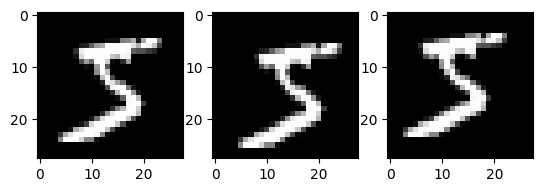

In [5]:
# Show shifted images
img_indx = 0
img, correct_class = mnist_data_train[img_indx]
img = img[0,:]
img_lr = np.roll(np.roll(img, 1, axis=1), 1, axis=0)
img_ul = np.roll(np.roll(img, -1, axis=1), -1, axis=0)

f, axarr = plt.subplots(1,3)
axarr[0].imshow(img, cmap='gray')
axarr[1].imshow(img_lr, cmap='gray')
axarr[2].imshow(img_ul, cmap='gray')
plt.show()

In [6]:
# Simple CNN from Week 5
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


model_cnn = SimpleCNN()
model = model_cnn.cpu().eval()


def pred(model, img):
    with torch.no_grad():
        w, h = img.shape
        if not isinstance(img, torch.Tensor):
            img = torch.tensor(img)

        x = img.reshape(1, -1, w, h)
        logits = model(x)
        y_hat = F.softmax(logits, dim=1)
        return y_hat.numpy().flatten()

In [7]:
img_pred = pred(model, img)
img_lr_pred = pred(model, img_lr)
img_ul_pred = pred(model, img_ul)

print("Org Img Class {} Prob:".format(correct_class), img_pred[correct_class])
print("Lower Right Img Class {} Prob:".format(correct_class), img_lr_pred[correct_class])
print("Upper Left Img Class {} Prob:".format(correct_class), img_ul_pred[correct_class])

Org Img Class 5 Prob: 0.11077551
Lower Right Img Class 5 Prob: 0.11008827
Upper Left Img Class 5 Prob: 0.10953918


In [8]:
# ============================================================
# B. CNN WITH MAX POOLING
# ============================================================

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

C = 1
filters = 32
classes = 10
D = 28 * 28

# FIX: Apply SAME normalization used in SimpleCNN
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

mnist_train = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_test = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

mnist_train_loader = DataLoader(mnist_train, batch_size=64, shuffle=True)
mnist_test_loader = DataLoader(mnist_test, batch_size=64, shuffle=False)

# CNN with Pooling (from the assignment)
model_cnn_pool = nn.Sequential(
    nn.Conv2d(C, filters, 3, padding=3//2),
    nn.Tanh(),
    nn.Conv2d(filters, filters, 3, padding=3//2),
    nn.Tanh(),
    nn.Conv2d(filters, filters, 3, padding=3//2),
    nn.Tanh(),
    nn.MaxPool2d(2),
    nn.Conv2d(filters, 2*filters, 3, padding=3//2),
    nn.Tanh(),
    nn.Conv2d(2*filters, 2*filters, 3, padding=3//2),
    nn.Tanh(),
    nn.Conv2d(2*filters, 2*filters, 3, padding=3//2),
    nn.Tanh(),
    nn.MaxPool2d(2),
    nn.Flatten(),
    nn.Linear(2*filters * (D // (4**2)), classes),
)

loss_func = nn.CrossEntropyLoss()

def train_simple_network(model, loss_func, train_loader, test_loader, score_funcs, device, epochs=20):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    history = {"epoch": [], "test Accuracy": []}

    for epoch in tqdm(range(epochs)):
        model.train()
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = loss_func(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        model.eval()
        all_preds, all_labels = [], []
        with torch.no_grad():
            for images, labels in test_loader:
                images = images.to(device)
                outputs = model(images)
                preds = torch.argmax(outputs, dim=1).cpu().numpy()
                all_preds.extend(preds)
                all_labels.extend(labels.numpy())

        acc = score_funcs["Accuracy"](all_labels, all_preds)
        history["epoch"].append(epoch+1)
        history["test Accuracy"].append(acc)

    return history


cnn_results_with_pool = train_simple_network(
    model_cnn_pool,
    loss_func,
    mnist_train_loader,
    mnist_test_loader,
    score_funcs={"Accuracy": accuracy_score},
    device=device,
    epochs=20
)


100%|██████████| 20/20 [05:55<00:00, 17.80s/it]


100%|██████████| 20/20 [05:27<00:00, 16.40s/it]


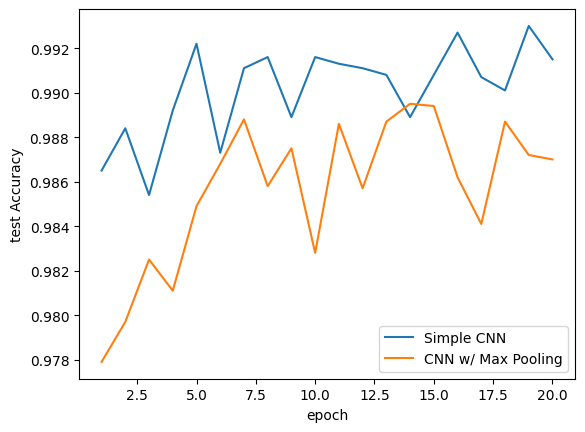

In [9]:
# Also train the SimpleCNN for comparison
simple_cnn_model = SimpleCNN()
cnn_results = train_simple_network(
    simple_cnn_model,
    loss_func,
    mnist_train_loader,
    mnist_test_loader,
    score_funcs={"Accuracy": accuracy_score},
    device=device,
    epochs=20
)

sns.lineplot(x='epoch', y='test Accuracy', data=cnn_results, label='Simple CNN')
sns.lineplot(x='epoch', y='test Accuracy', data=cnn_results_with_pool, label='CNN w/ Max Pooling')
plt.show()


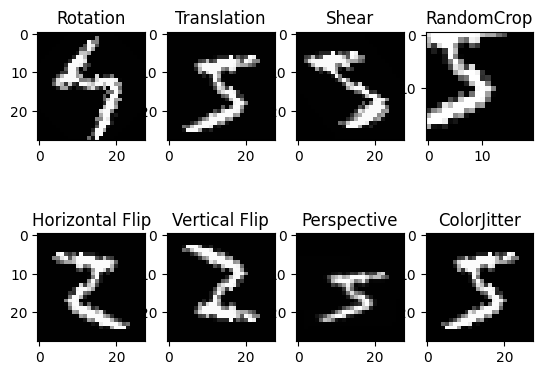

In [10]:
# ============================================================
# C. DATA AUGMENTATION
# ============================================================

sample_transforms = {
    "Rotation": transforms.RandomAffine(degrees=45),
    "Translation": transforms.RandomAffine(degrees=0, translate=(0.1,0.1)),
    "Shear": transforms.RandomAffine(degrees=0, shear=45),
    "RandomCrop": transforms.RandomCrop((20,20)),
    "Horizontal Flip": transforms.RandomHorizontalFlip(p=1.0),
    "Vertical Flip": transforms.RandomVerticalFlip(p=1.0),
    "Perspective": transforms.RandomPerspective(p=1.0),
    "ColorJitter": transforms.ColorJitter(brightness=0.9, contrast=0.9)
}

pil_img = transforms.ToPILImage()(img)

f, axarr = plt.subplots(2,4)
for count, (name, t) in enumerate(sample_transforms.items()):
    row = count % 4
    col = count // 4
    axarr[col,row].imshow(t(pil_img), cmap='gray')
    axarr[col,row].set_title(name)
plt.show()

In [11]:
# FIX: Augmented train set also needs NORMALIZATION after the transform
train_transform = transforms.Compose([
    transforms.RandomAffine(degrees=5, translate=(0.05, 0.05), scale=(0.98, 1.02)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

B = 64

mnist_train_t = torchvision.datasets.MNIST("./data", train=True, transform=train_transform)
mnist_test_t = torchvision.datasets.MNIST("./data", train=False, transform=test_transform)

mnist_train_loader_t = DataLoader(mnist_train_t, shuffle=True, batch_size=B, num_workers=2)
mnist_test_loader_t  = DataLoader(mnist_test_t, batch_size=B, num_workers=2)

In [12]:
# Same CNN architecture again
model_cnn_pool_aug = nn.Sequential(
    nn.Conv2d(C, filters, 3, padding=3//2),
    nn.Tanh(),
    nn.Conv2d(filters, filters, 3, padding=3//2),
    nn.Tanh(),
    nn.Conv2d(filters, filters, 3, padding=3//2),
    nn.Tanh(),
    nn.MaxPool2d(2),
    nn.Conv2d(filters, 2*filters, 3, padding=3//2),
    nn.Tanh(),
    nn.Conv2d(2*filters, 2*filters, 3, padding=3//2),
    nn.Tanh(),
    nn.Conv2d(2*filters, 2*filters, 3, padding=3//2),
    nn.Tanh(),
    nn.MaxPool2d(2),
    nn.Flatten(),
    nn.Linear(2*filters*D//(4**2), classes),
)

cnn_results_with_pool_augmented = train_simple_network(
    model_cnn_pool_aug,
    loss_func,
    mnist_train_loader_t,
    mnist_test_loader_t,
    score_funcs={"Accuracy": accuracy_score},
    device=device,
    epochs=20
)

 15%|█▌        | 3/20 [01:24<07:57, 28.09s/it]


KeyboardInterrupt: 

In [ ]:
sns.lineplot(x='epoch', y='test Accuracy', data=cnn_results_with_pool, label='CNN w/ Max Pooling')
sns.lineplot(x='epoch', y='test Accuracy', data=cnn_results_with_pool_augmented, label='CNN w/ Max Pooling + Augmentation')
plt.show()